In [343]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import PolynomialFeatures
import seaborn

### Importing and Data Preparation ###

First, we will import our dataset, which consists of our monthly economic indicators that we will use as features, as well as our monthly MCI scores. While we are interested in predicting future Michigan Consumer Sentiment data, we will first take the difference of our MCI values. We do this because we are more interested in predicitng the changes of MCI rather than the actual values. This also follows how we prepare the rest of the data: when it comes to constantly increasing indicicators, we can only look into the change in growth. Because our predictors are changes, it makes sense that we are also predicting changes. Furthermore, to ensure stationary features, we decide to take the difference. 

** Adding Lags and Dealing with Indicator Release Dates **
Following time series forecasting, it is also important that we add lags into our model. To decide on the total number of lags, we will first include a years worth of lags for each variable, as well as the lags for the past year's consumer sentiment data. We decided to include a year's worth of lags to account for the seasonality of our indicators. Furthermore, we also believe that it is extremely important to limit our predictors to include only information that is released prior to the sentiment scores. As a result, we only to include cocurrent data if it is released before consument sentiment. In the scope of this project, this means that we will include cocorruent data for jobless claims and M2 money supply alongisde our 12 monthly lags, and we will only include the monthly lags for Personal Consumer Expenditure and unemployment rate. For GDP, this data is released quarterly after consumer sentiment; thus, we will include the quarterly data for a year. 

In [344]:
collective_data = pd.read_csv('datasets/collective_data.csv')

In [345]:
#Extract mci data
mci_data = collective_data.iloc[:,6:7].values
mci = np.diff(mci_data, axis=0)

In [346]:
#Create functions to include lags, depending on relesae dates
def add_lags(data):
    data_lags = pd.concat([data.shift(i) for i in range(0, 13)], axis = 1)
    return data_lags
def add_lags_after(data):
    data_lags = pd.concat([data.shift(i) for i in range(1, 13)], axis = 1)
    return data_lags
def add_lags_gdp(data):
    data_lags = pd.concat([data.shift(3), data.shift(6), data.shift(9), data.shift(12)], axis = 1)
    return data_lags

In [347]:
#Generate the lags for each indicator and concatenate them to create a dataframe of all our data
mci = pd.DataFrame(mci)
date = collective_data.iloc[:,0:1]
pce = collective_data.iloc[:,1:2]
gdp = collective_data.iloc[:,2:3]
ur = collective_data.iloc[:,3:4]
m2 = collective_data.iloc[:,4:5]
jobless = collective_data.iloc[:,5:6]

pce_lags = add_lags_after(pce)
gdp_lags = add_lags_gdp(gdp)
ur_lags = add_lags_after(ur)
m2_lags = add_lags(m2)
jobless_lags = add_lags(jobless)
mci_lags = add_lags_after(mci)

all_data = pd.concat([gdp_lags, ur_lags, m2_lags, jobless_lags, mci_lags, mci], axis=1)

### Modeling: Training, Cross Validating, and Testing our Data ###

The first step in our modeling process is to split our data in train and test data. Normally, best data science practice dictates that we randomly split our dataset into train and test data. However, in this project, we are more interested in predicting future sentiment scores than overall accuracy. Consequently, we will split our test data to be in the final 25% of our data and and our training data to be the first 75%. The reason that we index our training set at 60 instead of 0 is because we have different amounts of data for different times; indexing at 60 was the time at which there was complete data for the months. 

As we ran our models, we discovered that taking the difference of the differences proved to be more accurate than just regressing on the differences. Because we are able to extrapolate predicted MCI through both methods, using the more accurate features would make more sense. As a result, we decided to use the differences of the differences. 

Next, we will undergo variable selection. Because each feature is unique, the number of lags to include will be different. To optimize which features to use, we have two options: we can either undergo running a grid search validation with difference number of lags and choosing the model with the lowest BIC score, or we can use a Lasso Regression and see which coefficients the regression brings to zero. Then, we would remove these variables. Ultimately, we decided that running regressions with each combination of lags would be computationally expensive, so we decided to use Lasso regression. 

For cross validation, we first had to ensure that we used enough data points to train. By allocating 200 data points to train and testing on 45 of those, we could be fairly confident that we were not over fitting. Normally, cross validation would slice up our train data set into folds and then test on each fold. However, with our time series data, we are only interested predicting in the future. Thus, we created our own version of cross validation. For each alpha value for our Lasso model, we will randomly select a month and then train on the proceeding 200 months and then test on the next 45 months. We will do this 10 times for each alpha value and then compare which tuning value had the highest R^2. After doing this, we will select the tuning paramter with the highest R^2 value and run this model on the testing data. We will then select the features that have a coefficient of zero and then remove these features for variable selection.

After undergoing variable selection, we will perform our final modeling. For our final model, we decided to use Ridge Regression. The reason we chose to use Ridge Regression as our final model is because Ridge performs the best under potential multicollinearity. Because we are using lags, it is very possible that our features are highly correlated. Therefore, we will use ridge regression. We will use cross validation the same way we did in variable selection. 

In [348]:
#Split our data into train and test
train = np.diff(all_data.iloc[60:340,:].values, axis = 0)
test = np.diff(all_data.iloc[340:464,:].values, axis = 0)
x_train = np.diff(all_data.iloc[60:340,:-1].values, axis = 0)
y_train = np.diff(all_data.iloc[60:340,-1].values, axis = 0)
x_test = np.diff(all_data.iloc[340:464,:-1], axis = 0)
y_test = np.diff(all_data.iloc[340:464,-1], axis = 0)

In [349]:
##create a boostrap function to cross validate the best c value for Lasso
#The idea is that the purpose of our test is to predict future values
#as a result, instead of using k fold cv, which will choose each fold as a test data, we will randomly sample
#sequences of data within our training data and then score them
#we will do this for a variety of c values and see how to fix it
import random

def boot_lasso(x, y):
    avg_acc = []
    n = x.shape[0]
    for i in range(-7, 8):
        k = 10**i
        acc = 0
        for j in range(0,10):
            m = random.randint(0,n-245)
            x_train = x[m:m+200]
            y_train = y[m:m+200]
            x_test = x[m+200:m+244]
            y_test = y[m+200:m+244]
            lasso = linear_model.Lasso(alpha = k)
            lasso.fit(x_train, y_train)
            score = lasso.score(x_test, y_test)
            acc += score
        avg_acc.append(acc/10)
    return np.argmax(avg_acc) -7, avg_acc
        

In [350]:
best_alpha, scores = boot_lasso(x_train, y_train)

In [351]:
lasso = linear_model.Lasso(alpha = 10**best_alpha)
lasso.fit(x_train, y_train)
lasso_coefs = lasso.coef_

In [352]:
coef_lst = []
for i in range(0, len(lasso_coefs)):
    if (lasso_coefs[i] == 0):
        coef_lst.append(i)

In [353]:
new_data = all_data.drop(all_data.columns[coef_lst], axis = 1)

In [367]:
#Split our data into train and test
train = np.diff(new_data.iloc[60:396,:].values, axis = 0)
test = np.diff(new_data.iloc[396:464,:].values, axis = 0)
x_train = np.diff(new_data.iloc[60:340,:-1].values, axis = 0)
y_train = np.diff(new_data.iloc[60:340,-1].values, axis = 0)
x_test = np.diff(new_data.iloc[340:464,:-1], axis = 0)
y_test = np.diff(new_data.iloc[340:464,-1], axis = 0)

In [392]:
##create a boostrap function to cross validate the best c value for Lasso
#The idea is that the purpose of our test is to predict future values
#as a result, instead of using k fold cv, which will choose each fold as a test data, we will randomly sample
#sequences of data within our training data and then score them
#we will do this for a variety of c values and see how to fix it
import random

def boot_ridge(x, y):
    avg_acc = []
    n = x.shape[0]
    for i in range(-7, 8):
        k = 10**i
        acc = 0
        for j in range(0,10):
            m = random.randint(0,n-245)
            x_train = x[m:m+200]
            y_train = y[m:m+200]
            x_test = x[m+200:m+244]
            y_test = y[m+200:m+244]
            lasso = linear_model.Ridge(alpha = k)
            lasso.fit(x_train, y_train)
            score = lasso.score(x_test, y_test)
            acc += score
        avg_acc.append(acc/10)
    return np.argmax(avg_acc) -7, avg_acc
        

In [393]:
best_a, scores = boot_ridge(x_train, y_train)

In [394]:
ridge = linear_model.Ridge(alpha = best_a)
ridge.fit(x_train, y_train)
diffdiff_pred = ridge.predict(x_test)
score = ridge.score(x_test, y_test)

In [399]:
print 'The R^2 of this baseline model is ' + str(score)

The R^2 of this baseline model is 0.445871976173


### Baseline Results ###

After tuning our ridge regression model, we receive a final R^2 value of .446.

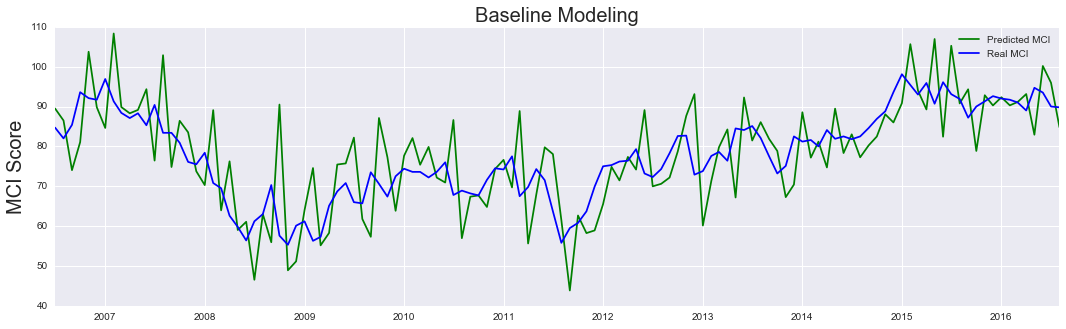

In [398]:
m = mci_data[341:464]
m = m.ravel()
diff = mci[340:464].values
diff = diff.ravel()
diffdiff = np.diff(diff, axis=0)


mci_pred = []
for i in range(1, len(diffdiff_pred)):
    d = diffdiff_pred[i] + diff[i-1]
    pred = m[i-1] + d
    mci_pred.append(pred)
    
mci_pred
rm = m[1:]
dat = date[342:464].values

date_lst = []
for i in range(0, dat.shape[0]):
    u = str(dat[i])
    u = u.replace(',', '')
    u = u.replace("'", '')
    u = u.replace('[', '')
    u = u.replace(']', '')
    u = datetime.strptime(u, '%d-%b-%y')
    date_lst.append(u)
# plt.figure(figsize=(18,5))
# pred, = plt.plot(date_lst, mci_pred, c='green')
# real, = plt.plot(date_lst, rm, c='blue')


# plt.legend((pred, real), ('Predicted MCI', "Real MCI"))

# plt.ylabel("MCI Scores", fontsize = 20)
# plt.suptitle('Sentiment Modeling Results')
# plt.show()

fig, ax = plt.subplots(figsize=(18,5))
pred, = ax.plot(date_lst, mci_pred, c='green')
real, = ax.plot(date_lst, rm, c='blue')
ax.set_ylabel("MCI Score", fontsize = 20)
ax.set_title("Baseline Modeling", fontsize = 20)
ax.legend((pred, real), ('Predicted MCI', "Real MCI"))
plt.show()